## Romberg Integration = Richardson Extrapolation 

Romberg Integration is just Richardson Extrapolation(KC 7.1) applied
to numerical integration.  Here we apply it to the composite trapezoidal 
rule.

We look at integrating 
$$
\int_0^1 \frac{1}{\sqrt{2\pi}}e^{-x^2/2},
$$
which gives the percentile of a standard, normally distributed population lying between the mean and one standard deviation.

We start with 8 intervals(9 points between 0 and 1 inclusive)

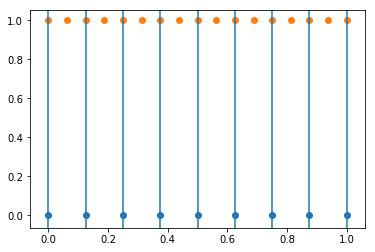

In [2]:
import numpy as np
import matplotlib.pyplot as plt
def integrand(x):
    return 1.0/(2*np.pi)**.5*np.exp(-x**2/2)

hmesh=np.linspace(0,1,9)

halfmesh=np.linspace(0,1,17)

plt.scatter(hmesh,np.zeros(9))
plt.scatter(halfmesh,np.ones(17))
for x in hmesh:
    plt.axvline(x)
plt.show()


Note that the sample values for the integrand are nested.  This is **not true** for the midpoint rule.

Also note that for $n$ intervals, 
$$
I(h)= \frac{h}{2}\left(f(x_0) + 2\sum_{i=1}^{n-1} f(x_i) + f(x_n)\right)
$$

and that for $2n$ intervals(i.e. $h/2$),
$$
I(\frac{h}{2}) = \frac{I(h)}{2} + \frac{h}{2}\sum_{x_i \in \text{new points}} f(x_i)
$$

In [4]:

def base_trap(integrand,hmesh):
    length=hmesh.size
    trap=.5/(length-1)*(integrand(hmesh[0])+integrand(hmesh[-1])
                              +2*np.sum(integrand(hmesh[1:-1])))
    return trap

length=hmesh.size
xnew=.5*(hmesh[0:length-1]+hmesh[1:length])
halfmesh=np.zeros(length+xnew.size)
print(halfmesh.size)
halfmesh[0::2]=hmesh 
halfmesh[1::2]=xnew

halftrap=.5*trap+.5/(length-1)*(np.sum(integrand(xnew)))

print(trap,halftrap)

extrapol= (4*halftrap - trap)/3
print(extrapol)


17


NameError: name 'trap' is not defined

In [5]:
def merge(x,y):
    temp=np.zeros(x.size+y.size) #merges vector with vector of midpoints
    temp[0::2]=x
    temp[1::2]=y
    return temp

def bisect(x):
    return .5*(x[0:-1]+x[1:]) #returns midpoints of x

def Romberg(integrand,a=0,b=1,levels=4,pts=2):
    R=np.zeros((levels,levels))
    pts=np.linspace(a,b,pts) #initial level, h=b-a
    h=b-a
    R[0,0]=base_trap(integrand,pts) #trap rule with 1 interval
    for i in range(1,levels):
        new=bisect(pts)  #split the interval in half
        h=.5*h
        R[i,0]=.5*R[i-1,0]+h*np.sum(integrand(new)) #composite trap rule
        pts=merge(pts,new)
        for j in range(1,i+1): #fill in columns using extrapolation
            R[i,j]=(4**j*R[i,j-1]-R[i-1,j-1])/(4**j-1) #extrapolation
    print(R) #print the Romberg table
    return R

integ=Romberg(integrand,levels=6)

[[ 0.3204565   0.          0.          0.          0.          0.        ]
 [ 0.33626091  0.34152905  0.          0.          0.          0.        ]
 [ 0.34008184  0.34135549  0.34134392  0.          0.          0.        ]
 [ 0.34102952  0.34134541  0.34134473  0.34134475  0.          0.        ]
 [ 0.34126597  0.34134479  0.34134475  0.34134475  0.34134475  0.        ]
 [ 0.34132505  0.34134475  0.34134475  0.34134475  0.34134475  0.34134475]]


## Convergence Rate

Let's integrate $e^x$ on [0,1] using Romberg integration.

We also compare versus the composite trapezoidal rule, which uses the
same number of evaluations of the integrand.

[[ 1.85914091  0.          0.          0.          0.          0.        ]
 [ 1.75393109  1.71886115  0.          0.          0.          0.        ]
 [ 1.7272219   1.71831884  1.71828269  0.          0.          0.        ]
 [ 1.72051859  1.71828415  1.71828184  1.71828183  0.          0.        ]
 [ 1.71884113  1.71828197  1.71828183  1.71828183  1.71828183  0.        ]
 [ 1.71842166  1.71828184  1.71828183  1.71828183  1.71828183  1.71828183]]


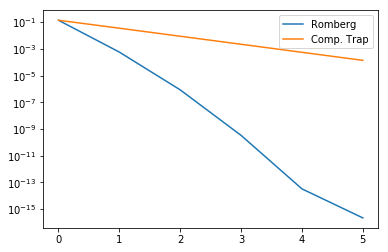

In [6]:
def myfunc(x):
    return np.exp(x)

inte=Romberg(myfunc,levels=6) #Romberg with 6-levels
exact=np.exp(1)-1 #exact integral
err=np.zeros(6)
err=np.absolute(np.diag(inte)-exact) #diag of Romberg mat is best appr.
err2=np.absolute(inte[:,0]-exact) #First Column is composite trap rule
plt.semilogy(err,label='Romberg')
plt.semilogy(err2,label='Comp. Trap')
plt.legend()
plt.show()

### Adaptive Romberg

One version of Romberg integration repeatedly subdivides, but stops when
$|R[i,i]-R[i-1,i-1]|<tol$, i.e. the value of the integrand doesn't change by much from one level to the next.  This tolerance could be absolute or relative.


In [7]:
def Adapt_Romberg(integrand,a=0,b=1,tolerance=1E-12,levels=10):
    R=np.zeros((levels,levels))
    pts=np.linspace(a,b,2) #initial level, h=b-a
    h=b-a
    R[0,0]=base_trap(integrand,pts)
    lev=1
    tol_met=False
    while not tol_met and lev < levels:
        new=bisect(pts)  #split the interval in half
        h=.5*h
        R[lev,0]=.5*R[lev-1,0]+h*np.sum(integrand(new)) #composite trap rule
        pts=merge(pts,new)
        for j in range(1,lev+1): #fill in columns using extrapolation
            R[lev,j]=(4**j*R[lev,j-1]-R[lev-1,j-1])/(4**j-1) #extrapolation
        if np.absolute(R[lev,lev]-R[lev-1,lev-1]) < tolerance:
            tol_met=True
        lev+=1
    print(R) #print the Romberg table
    return R[lev-1,lev-1],R

def tough(x):
    return 1+np.sin(np.exp(3*x))
int=Adapt_Romberg(integrand)
int2=Adapt_Romberg(tough)

[[ 0.3204565   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.33626091  0.34152905  0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.34008184  0.34135549  0.34134392  0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.34102952  0.34134541  0.34134473  0.34134475  0.          0.          0.
   0.          0.          0.        ]
 [ 0.34126597  0.34134479  0.34134475  0.34134475  0.34134475  0.          0.
   0.          0.          0.        ]
 [ 0.34132505  0.34134475  0.34134475  0.34134475  0.34134475  0.34134475
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.   

In [43]:
print(int2)

1.20204149114


In [45]:
print(np.diag(int2[1]))

[ 1.892971    0.6486526   1.29055865  1.44631865  1.13611722  1.20483696
  1.20204307  1.20204119  1.20204149  1.20204149]


In [46]:
temp=np.diag(int2[1])
print(temp[-1]-temp[-2])

-6.04957417494e-10
